# Tutorial - Time series forecasting

## Introduction

Time series are an ubiquitous type of data in all types of processes. Producing forecasts for them can be highly valuable in domains like retail or industrial manufacture, among many others.

Lightwood supports time series forecasting (both univariate and multivariate inputs), handling many of the pain points commonly associated with setting up a manual time series predictive pipeline. 

In this tutorial, we will train a lightwood predictor and analyze its forecasts for the task of counting sunspots in monthly intervals.

## Load data

Let's begin by loading the dataset and looking at it:

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/mindsdb/benchmarks/main/benchmarks/datasets/monthly_sunspots/data.csv")
df

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
...,...,...
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3


This is a very simple dataset. It's got a single column that specifies the month in which the measurement was done, and then in the 'Sunspots' column we have the actual quantity we are interested in forecasting. As such, we can characterize this as a univariate time series problem.

## Define the predictive task

We will use Lightwood high level methods to state what we want to predict. As this is a time series task (because we want to leverage the notion of time to predict), we need to specify a set of arguments that will activate Lightwood's time series pipeline:

In [2]:
from lightwood.api.high_level import ProblemDefinition

INFO:lightwood-2177:No torchvision detected, image helpers not supported.
INFO:lightwood-2177:No torchvision/pillow detected, image encoder not supported


In [3]:
tss = {'nr_predictions': 6,   # the predictor will learn to forecast what the next semester counts will look like (6 data points at monthly intervals -> 6 months)
       'order_by': ['Month'], # what column is used to order the entire datset
       'window': 12           # how many past values to consider for emitting predictions
      }

pdef = ProblemDefinition.from_dict({'target': 'Sunspots',         # specify the column to forecast
                                    'timeseries_settings': tss    # pass along all time series specific parameters
                                   })

Now, let's do a very simple train-test split, leaving 10% of the data to check the forecasts that our predictor will produce:

In [4]:
cutoff = int(len(df)*0.9)

train = df[:cutoff]
test = df[cutoff:]

print(train.shape, test.shape)

(2538, 2) (282, 2)


## Generate the predictor object

Now, we can generate code for a machine learning model by using our problem definition and the data:

In [5]:
from lightwood.api.high_level import (
    json_ai_from_problem,
    code_from_json_ai,
    predictor_from_code
)

json_ai = json_ai_from_problem(df, problem_definition=pdef)
code = code_from_json_ai(json_ai)
predictor = predictor_from_code(code)

# uncomment this to see the generated code:
# print(code)

INFO:lightwood-2177:Dropping features: []
INFO:lightwood-2177:Analyzing a sample of 2467
INFO:lightwood-2177:from a total population of 2820, this is equivalent to 87.5% of your data.
INFO:lightwood-2177:Infering type for: Month
INFO:lightwood-2177:Column Month has data type date
INFO:lightwood-2177:Infering type for: Sunspots
INFO:lightwood-2177:Column Sunspots has data type float
/home/runner/work/lightwood/lightwood/lightwood/helpers/text.py:242: RuntimeWarning: invalid value encountered in double_scalars
  randomness_per_index.append(S / np.log(N))
INFO:lightwood-2177:Starting statistical analysis
INFO:lightwood-2177:Finished statistical analysis
INFO:lightwood-2177:Unable to import black formatter, predictor code might be a bit ugly.


## Train

Okay, everything is ready now for our predictor to learn based on the training data we will provide.

Internally, lightwood cleans and reshapes the data, featurizes measurements and timestamps, and comes up with a handful of different models that will be evaluated to keep the one that produces the best forecasts.

Let's train the predictor. This should take a couple of minutes, at most:

In [6]:
predictor.learn(train)

INFO:lightwood-2177:Dropping features: []
INFO:lightwood-2177:Performing statistical analysis on data
INFO:lightwood-2177:Starting statistical analysis
INFO:lightwood-2177:Finished statistical analysis
INFO:lightwood-2177:Cleaning the data
INFO:lightwood-2177:Transforming timeseries data
INFO:lightwood-2177:Using 1 processes to reshape.
INFO:lightwood-2177:Splitting the data into train/test
INFO:lightwood-2177:Preparing the encoders
INFO:lightwood-2177:Encoder prepping dict length of: 1
INFO:lightwood-2177:Done running for: Sunspots
INFO:lightwood-2177:time series encoder epoch [1/100000] average_loss = 0.01813966171545239
INFO:lightwood-2177:time series encoder epoch [2/100000] average_loss = 0.0071897343871054845
INFO:lightwood-2177:time series encoder epoch [3/100000] average_loss = 0.005507370793046968
INFO:lightwood-2177:time series encoder epoch [4/100000] average_loss = 0.004826837527564027
INFO:lightwood-2177:time series encoder epoch [5/100000] average_loss = 0.004513632186448

## Predict

Once the predictor has trained, we can use it to generate 6-month forecasts for each of the test set data points:

In [7]:
forecasts = predictor.predict(test)

INFO:lightwood-2177:Dropping features: []
INFO:lightwood-2177:Cleaning the data
INFO:lightwood-2177:Transforming timeseries data
INFO:lightwood-2177:Featurizing the data
INFO:lightwood-2177:The block ICP is now running its explain() method
INFO:lightwood-2177:The block AccStats is now running its explain() method
INFO:lightwood-2177:AccStats.explain() has not been implemented, no modifications will be done to the data insights.


Let's check how a single row might look:

In [8]:
forecasts.iloc[[10]]

,prediction,order_Month,confidence,lower,upper
10,"[67.52756269823574, 71.64786186327231, 66.3184...","[-271987200.0, -269308800.0, -266630400.0, -26...","[0.68, 0.68, 0.68, 0.68, 0.68, 0.68]","[53.1312340293017, 54.82074731148823, 47.41232...","[81.92389136716977, 88.47497641505639, 85.2246..."


You'll note that the point `prediction` has associated `lower` and `upper` bounds that are a function of the estimated `confidence` the model has on its own output. Apart from this, `order_Month` yields the timestamps of each prediction, the `anomaly` tag will let you know if the observed value falls outside of the predicted region. 


## Visualizing a forecast

Okay, time series are much easier to appreciate through plots. Let's make one:

NOTE: We will use `matplotlib` to generate a simple plot of these forecasts. If you want to run this notebook locally, you will need to `pip install matplotlib` for the following code to work.

In [9]:
import matplotlib.pyplot as plt

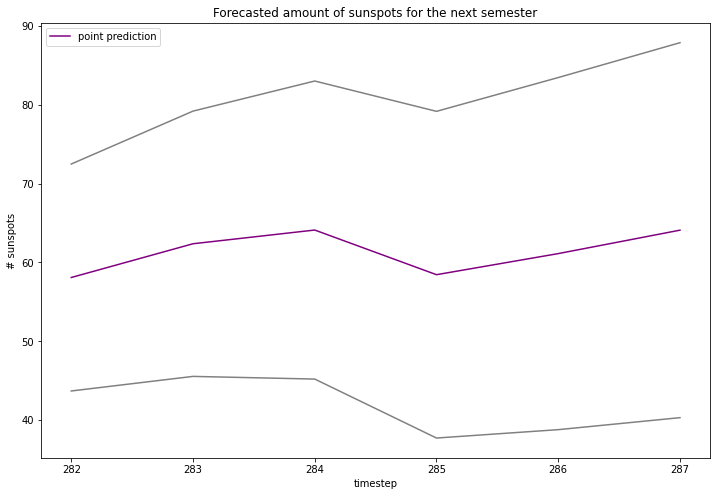

In [10]:
plt.figure(figsize=(12, 8))
plt.plot([None for _ in range(forecasts.shape[0])] + forecasts.iloc[-1]['prediction'], color='purple', label='point prediction')
plt.plot([None for _ in range(forecasts.shape[0])] + forecasts.iloc[-1]['lower'], color='grey')
plt.plot([None for _ in range(forecasts.shape[0])] + forecasts.iloc[-1]['upper'], color='grey')
plt.xlabel('timestep')
plt.ylabel('# sunspots')
plt.title("Forecasted amount of sunspots for the next semester")
plt.legend()
plt.show()

## Conclusion

In this tutorial, we have gone through how you can train a machine learning model with Lightwood to produce forecasts for a univariate time series task.

There are additional parameters to further customize your timeseries settings and/or prediction insights, so be sure to check the rest of the documentation.